### **Implementing a KNN Regressor**

In [2]:
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree
import scipy
import sklearn
from sklearn.datasets import load_diabetes
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate

##### **Define The KNN Regressor class**

In [ ]:
class KnnRegressor(BaseEstimator):
    """
    k-Nearest Neighbors regressor using a KD-tree for fast neighbor search.

    :Parameters:
    ----------
    k : int -> Number of nearest neighbors to use for prediction.
    """
    def __init__(self, k): 
        self.k = k

    def fit(self, x, y):
        """
        Fit the kNN regressor.

        :Parameters:
        x : array-like of shape (n_samples, n_features) -> Training data 
        y : array-like of shape (n_samples,)-> Target values 

        :Output:
        self : object -> Fitted estimator.
        """
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self
        
    def predict(self, x):
        """
        Predict target values for given samples.

        :Parameters:
        x : array-like of shape (n_samples, n_features) -> Input samples.

        :Output: y_pred : ndarray of shape (n_samples,) -> Predicted target values.
        """
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]

        #calculate mean of k nearest neighbours
        m = np.mean(neighbour_labels, axis=1)
        
        return m

##### **Testing implementation with diabetes dataset** 

The diabetes dataset used is from sklearn's native datasets. It is comprised of 442 patient summaries and is used in diabetes prediction. The following are the features included: 

| Feature | Meaning                         |
| ------- | ------------------------------- |
| `age`   | Age of the patient              |
| `sex`   | Biological sex                  |
| `bmi`   | Body mass index                 |
| `bp`    | Average blood pressure          |
| `s1`    | Total serum cholesterol         |
| `s2`    | Low-density lipoproteins (LDL)  |
| `s3`    | High-density lipoproteins (HDL) |
| `s4`    | Total cholesterol / HDL         |
| `s5`    | Log of serum triglycerides      |
| `s6`    | Blood sugar level               |


In [ ]:
diabetes = sklearn.datasets.load_diabetes()
# print(diabetes.data.shape)
# print(diabetes.feature_names)
# diabetes.data[:5]

**Creating test and trainig data splits of diabetes data**

In [ ]:
def train_test_split(x, y, train_size=0.7, random_state=0):
    """
    Randomly split data into training and testing sets.

    :Parameters:
    ----------
    x : array-like of shape (n_samples, n_features) -> Input data.
    y : array-like of shape (n_samples,) -> Target values.
    train_size : float, default=0.7 -> Fraction of samples to include in the training set.
    random_state : int -> Seed for reproducible randomness.

    :Output:
    -------
    x_train : ndarray -> Training input data.
    x_test : ndarray -> Test input data.
    y_train : ndarray -> Training target values.
    y_test : ndarray -> Test target values.
    """
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N*train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    return x[idx_train], x[idx_test], y[idx_train], y[idx_test]

x_train, x_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, train_size=0.7, random_state=1)

##### **Apply K-nn regressor to predict diabetes**

In [ ]:
knn = KnnRegressor(k=5)
knn.fit(x_train, y_train)
y_hat_test = knn.predict(x_test)
y_hat_test[:10]

### **L-fold Cross Validation**
##### **Implementing a L-Fold Crosss Validation (CV) scheme**

In [ ]:
class LFold:
    """
    Repeated random train-test splitting (leave-fraction-out cross-validation).

    This class generates multiple random splits of the dataset into
    training and testing sets, using a fixed training fraction.

    :Parameters:
    reps : int -> Number of repeated random splits.
    train_size : float, default=0.7 -> Fraction of samples to include in the training set.
    random_state : int or None -> Seed for reproducible randomness.
    """

    def __init__(self, reps, train_size = 0.7, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        """
        Return the number of splitting iterations.

        :Output:
        n_splits : int -> Number of repeated splits.
        """
        return self.reps

    def split(self, x, y=None, groups=None):
        """
        Generate indices to split data into training and test sets.

        :Parameters:
        x : array-like of shape (n_samples, n_features)
            Input data to split.
        y : Ignored -> Included for compatibility with sklearn interfaces.
        groups : Ignored -> Included for compatibility with sklearn interfaces.

        :Output:
        -------
        train_idx : ndarray -> Indices of training samples.
        test_idx : ndarray -> Indices of test samples.
        """
        for _ in range(self.reps):
            train_idx = self.RNG.choice(np.arange(len(x)), size=round(self.train_size*len(x)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx

**Testing the L-fold cross validation method**

In [ ]:
for idx_train, idx_test in LFold(5).split(list(range(20))):
    print(idx_train, idx_test)


##### **Testing Parameter K (how many neighbours) on regresson model using L-Fold CV**

Evaluate kNN regression performance across a range of k values using cross-validation.

For each k in {1, ..., max_k}, this function:
- Fits a KnnRegressor(k)
- Runs cross-validation using the provided cv splitter
- Stores train and test mean squared error scores for each split


In [ ]:
def evaluation(max_k, cv):
    """
    :Parameters:
    ----------
    max_k : int -> Maximum number of nearest neighbours to evaluate (evaluates 1..max_k).
    cv : object -> Cross-validation splitter with methods get_n_splits() and split().

    :Output:
    -------
    train_results : ndarray of shape (reps, max_k) -> Train MSE scores for each split (rows) and k (columns).
    test_results : ndarray of shape (reps, max_k) -> Test MSE scores for each split (rows) and k (columns).
    """
    r = cv.get_n_splits()
    test_results = np.zeros(shape=(r, max_k))
    train_results = np.zeros(shape=(r, max_k))

    for k in range(1, max_k+1):
        knn = KnnRegressor(k)
        cv_res = cross_validate(knn, diabetes.data, diabetes.target, cv=cv, return_train_score=True, scoring=make_scorer(mean_squared_error))
        print(np.shape(cv_res['test_score']))
        print(cv_res['test_score'])
        test_results[:, k-1] = cv_res['test_score']
        train_results[:, k-1] = cv_res['train_score']
        
    return train_results, test_results

reps=25
max_k=30
train_results, test_results = evaluation(max_k, cv=LFold(reps))


#### **calculating the mean and standard deviation of the resulting error. across each respective value of k for all folds**

In [ ]:
#calculating the mean and standard deviation of the resulting error. across each respective value of k for all folds
train_mean = np.mean(train_results, axis=0)
train_std = np.std(train_results, axis=0)
test_mean = np.mean(test_results, axis=0)
test_std = np.std(test_results, axis=0)
print("train_mean", train_mean)
print("train_std", train_std)
print("test_mean", test_mean)
print("test_std", test_std)


#### **Visualising the results**

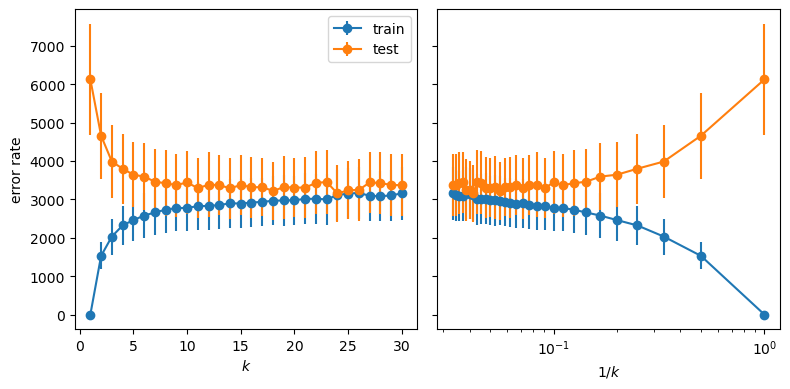

In [18]:
from matplotlib import pyplot as plt

ks = np.arange(1, max_k+1)
_, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)
z = (reps**0.5)/1.96
axs[0].errorbar(ks, train_mean, yerr = (train_mean + 1.96*train_std)/np.sqrt(reps), marker='o', label='train')
axs[0].errorbar(ks, test_mean, yerr = (test_mean + 1.96*test_std)/np.sqrt(reps), marker='o', label='test')
axs[0].legend()
axs[0].set_xlabel('$k$')
axs[0].set_ylabel('error rate')
axs[1].errorbar(1/ks, train_mean, yerr=(train_mean + 1.96*train_std)/np.sqrt(reps), marker='o', label='train')
axs[1].errorbar(1/ks, test_mean, yerr = (test_mean+ 1.96*test_std)/np.sqrt(reps), marker='o', label='test')
axs[1].set_xscale('log')
axs[1].set_xlabel('$1/k$')
plt.show()

### **Model Selection Based on Error Analysis**

From the plot above, a significant difference between training and test error rates is observed for small values of \( k \), particularly in the range **\( k = 1 \) to \( k = 5 \)**. This indicates strong overfitting when very few nearest neighbours are used.

For values of **\( k \)** in the range **5 to 20**:
- Training and test error rates begin to converge
- Generalisation performance improves
- Sensitivity to noise is reduced

For values of **\( k ≥ 22 \)**, model performance on unseen data deteriorates, indicating overfitting.

**Final choice of \( k \):**
- Acceptable range: **10 to 20**
- Selected value: **\( k ≈ 17 \)**
- Rationale: balances bias and variance while reducing computational cost

In [ ]:
L = [5, 10, 15, 20, 25]
train_results_L = []
test_results_L = []

for l in L:
    print('L: ', l)
    train_res, test_res = evaluation(max_k, LFold(l))
    train_results_L.append(train_res)
    test_results_L.append(test_res)

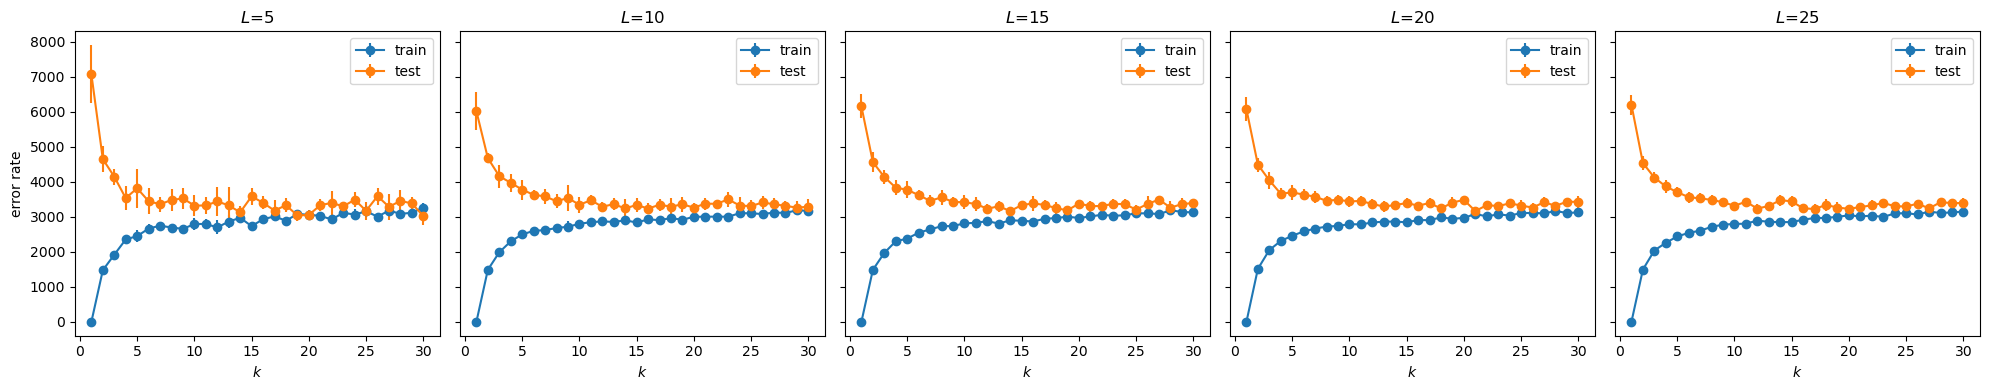

In [24]:
ks = np.arange(1, max_k+1)
_, axs = plt.subplots(1, len(L), figsize=(4*len(L),4), tight_layout=True, sharey=True)
for i, r in enumerate(L):
    z = r**0.5/1.96
    axs[i].set_title(f'$L$={r}')
    axs[i].errorbar(ks, train_results_L[i].mean(axis=0), yerr=train_results_L[i].std(axis=0)/z, marker='o', label='train')
    axs[i].errorbar(ks, test_results_L[i].mean(axis=0), yerr=test_results_L[i].std(axis=0)/z, marker='o', label='test')
    axs[i].set_xlabel('$k$')
    axs[i].legend()    
axs[0].set_ylabel('error rate')
plt.show()

### **Effect of Increasing L on Model Performance**

From the plots above, it can be observed that as **L increases**, both the training and testing error curves become smoother. This indicates a reduction in variance in the model’s mean error rates, although small perturbations are still visible in the test error curves.

Across all values of L, there is a significant risk of **overfitting** for small values of k, particularly in the range **k = 0 to 5**. This behaviour is consistent regardless of the chosen value of L.

Conversely, **underfitting** begins to emerge for larger values of k, particularly around **k = 30**. Models with **L = 15** and **L = 20** show an increased risk of underfitting across several values of k, as evidenced by a non-zero error rate combined with a negligible difference between training and test errors.

#### **Automatic Model Selection**

In [ ]:
from sklearn.base import BaseEstimator
class KnnRegressorCV(BaseEstimator):
    """
    k-Nearest Neighbors regressor with internal cross-validation for automatic selection of the optimal number of neighbours.

    :Parameters:
    ks : list of int, default=range(1, 21) -> Candidate values of k to evaluate.
    cv : object, default=LFold(5) -> Cross-validation splitter used to evaluate each k.
    """
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
        self.ks = ks
        self.cv = cv

    def fit(self, x, y):
        """
        Fit the kNN regressor and select the optimal value of k using cross-validation.

        :Parameters:
        x : array-like of shape (n_samples, n_features) -> Training input data.
        y : array-like of shape (n_samples,) -> Target values.

        :Output:
        self : object -> Fitted estimator with selected k.
        """
        self.y = y
        self.x = x
        cv_results = []
        for k in self.ks:
            knn = KnnRegressor(k)
            cv_res = cross_validate(knn, x, y, cv=self.cv, scoring=make_scorer(mean_squared_error))
            cv_results.append(np.mean(cv_res['test_score']))
        self.k_ = self.ks[np.argmin(cv_results)]
        self.knn_ = KnnRegressor(self.k_).fit(x, y)
        return self

    def predict(self, x):
        """
        Predict target values using the kNN model with the selected
        number of neighbours.

        :Parameters:
        x : array-like of shape (n_samples, n_features) -> Input samples.

        :Output:
        y_pred : ndarray of shape (n_samples,) -> Predicted target values.
        """
        return self.knn_.predict(x)
    

    

##### **A small experiment to see how stable the "optimal" K is when we refit the model multiple times** 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, train_size=0.7, random_state=0)

k_vals =[]
errors_cv = []

for i in range(1,50):
    
    knn = KnnRegressorCV(ks=list(range(1, 30)), cv=LFold(5))
    knn.fit(x_train, y_train)
    y_hat_test = knn.predict(x_test)
    errors_cv.append(mean_squared_error(y_test, y_hat_test))
    k_vals.append(knn.k_)

print(k_vals)
print("optimal k: ", np.floor(np.mean(k_vals)))



### **Analysis of Optimal k Selection Using Internal Cross-Validation**

The mean optimal value of k appears to lie within the range **18 to 20**. This finding is consistent with the results obtained previously, where values of k in this range were identified as optimal or near-optimal through visual inspection.

Several factors influence the effectiveness of the internal cross-validation method:

1. **Number of folds**  
   Using too few folds can lead to an oversimplification of the model and poor generalisation, while using too many folds may introduce redundancy in the training data and increase computational cost.

2. **Randomness**  
   The cross-validation procedure is inherently stochastic. Although some sources of randomness have been controlled, a degree of variability has been intentionally retained to illustrate its impact on the selected value of k. For this reason, an optimal *range* of k values is reported rather than a single fixed integer. While randomness affects all models to some extent, the approach used here aims to minimise its influence while still demonstrating its effect.